# Progressive GANS 


This is a Progressive GANS model inspired by https://research.nvidia.com/publication/2017-10_Progressive-Growing-of

In [0]:
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

from __future__ import print_function
import argparse
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

%matplotlib inline

In [2]:
# mounts the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Parameters

In [0]:
# Set random seed for reproducibility
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED)

# images
DATA_DIR = '/content/drive/My Drive/repos'
IMG_DIR = DATA_DIR + '/art_generator/data_raw/'
IMG_SIZE = 64
N_CHANNELS = 3

# graph
GEN_INPUT_SIZE = 100
N_LAYERS = 5
N_GEN_CHANNELS = 16
N_DISC_CHANNELS = 16
beta1 = 0.5

# training
N_EPOCHS = 50
LR = 0.0002
N_WORKERS = 2
BATCH_SIZE = 8
ngpu = 1

# checkpoints and logs
LOAD_CHECKPOINT = False # False will overwrite the existing checkpoint
CHECKPOINT_PTH = DATA_DIR + '/art_generator/data_out/model_checkpoints/checkpoint_1.pt'
LOGDIR = DATA_DIR + '/art_generator/data_out/logs/size-' + str(IMG_SIZE)

### Dataloader

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=IMG_DIR,
                           transform=transforms.Compose([
                               transforms.Resize(IMG_SIZE),
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.RandomVerticalFlip(p=0.5),
                               transforms.CenterCrop(IMG_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

print('Size of dataset: ' + str(len(dataloader.dataset.samples)))

Size of dataset: 326


In [0]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

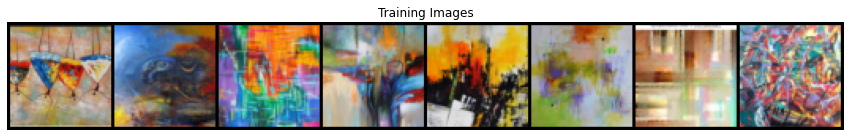

In [6]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Models

### Generator

In [0]:
class Generator(nn.Module):
    def __init__(self, ngpu, n_layers):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.n_layers = n_layers

        self.layers = nn.ModuleList([nn.ConvTranspose2d(GEN_INPUT_SIZE, N_GEN_CHANNELS * 2, 4, 1, 0, bias=False)])
        self.layers.extend([nn.ConvTranspose2d(N_GEN_CHANNELS * 2, N_GEN_CHANNELS * 2, 4, 2, 1, bias=False) for i in range(self.n_layers - 3)])
        self.layers.extend([nn.ConvTranspose2d(N_GEN_CHANNELS * 2, N_GEN_CHANNELS, 4, 2, 1, bias=False),
                            nn.ConvTranspose2d(N_GEN_CHANNELS, N_CHANNELS, 4, 2, 1, bias=False)])                   
                           
        self.batch1 = nn.BatchNorm2d(N_GEN_CHANNELS)
        self.batch2 = nn.BatchNorm2d(N_GEN_CHANNELS * 2)

        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()

    def forward(self, x):
        for i, name in enumerate(self.layers):
            x = self.layers[i](x)

            if self.layers[i].out_channels == N_GEN_CHANNELS * 2:
                x = self.batch2(x)
                x = self.relu(x)
            elif self.layers[i].out_channels == N_GEN_CHANNELS:
                x = self.batch1(x)
                x = self.relu(x)
            else:
                x = self.tanh(x)

        return x

In [9]:
# Create the generator
netG = Generator(ngpu, N_LAYERS).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

Generator(
  (layers): ModuleList(
    (0): ConvTranspose2d(100, 32, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (tanh): Tanh()
)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, n_layers):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.n_layers = n_layers

        self.layers = nn.ModuleList([nn.Conv2d(N_CHANNELS, N_DISC_CHANNELS * 2, 4, 2, 1, bias=False)])
        self.layers.extend([nn.Conv2d(N_DISC_CHANNELS * 2, N_DISC_CHANNELS * 2, 4, 2, 1, bias=False) for i in range(self.n_layers - 2)])
        self.layers.append(nn.Conv2d(N_DISC_CHANNELS * 2, 1, 4, 1, 0, bias=False))
                           
        self.batch2 = nn.BatchNorm2d(N_DISC_CHANNELS * 2)

        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):

        for i, name in enumerate(self.layers):
            x = self.layers[i](x)

            if i == 0:
                x = self.LeakyReLU(x)            
            elif self.layers[i].out_channels == N_DISC_CHANNELS * 2:
                x = self.batch2(x)
                x = self.LeakyReLU(x)
            else:
                x = self.sigmoid(x)

        return x

In [11]:
# Create the Discriminator
netD = Discriminator(ngpu, N_LAYERS).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

Discriminator(
  (layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): Conv2d(32, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyReLU): LeakyReLU(negative_slope=0.2)
  (sigmoid): Sigmoid()
)

### Loss functions and optimizers

In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, GEN_INPUT_SIZE, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(beta1, 0.999))

### Loads Checkpoint

In [0]:
if LOAD_CHECKPOINT:
    # loads the model weights
    checkpoint = torch.load(CHECKPOINT_PTH)
    netG.load_state_dict(checkpoint['netG_state'])
    optimizerG.load_state_dict(checkpoint['optimizerG'])
    netD.load_state_dict(checkpoint['netD_state'])
    optimizerD.load_state_dict(checkpoint['optimizerD'])
    print('Checkpoint Loaded')
    
    # loads the epoch counter
    with open(LOGDIR + '/itercount.txt', 'r') as f:
        epoch_counter = int(f.read())
else:
    epoch_counter = 0

## Training

In [14]:
# Training Loop
writer = SummaryWriter(LOGDIR)

# Lists to keep track of progress
img_list = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(N_EPOCHS):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, GEN_INPUT_SIZE, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Save the loss for the generator and discriminator
        writer.add_scalar('Loss/Gen', errG.item(), epoch_counter)
        writer.add_scalar('Loss/Disc', errD.item(), epoch_counter)

    # print the status
    print('EPOCH: [%d/%d] BATCH: [%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, N_EPOCHS, i, len(dataloader),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    # saves a checkpoint        
    checkpoint = {'netG_state': netG.state_dict(), 'optimizerG': optimizerG.state_dict(),
                    'netD_state': netD.state_dict(), 'optimizerD': optimizerD.state_dict()}
    torch.save(checkpoint, CHECKPOINT_PTH)
    
    # saves the epoch counter
    with open(LOGDIR + '/itercount.txt', 'w') as f:
        f.write(str(epoch_counter))
    epoch_counter += 1

    # Saves an image so we can view the progression
    with torch.no_grad():
        output = netG(fixed_noise).detach().cpu()
    grid = torchvision.utils.make_grid(output[0])
    writer.add_image('image_epoch_' + str(epoch_counter), grid)

writer.close()

Starting Training Loop...
EPOCH: [0/50] BATCH: [40/41]	Loss_D: 0.8933	Loss_G: 1.4167	D(x): 0.6269	D(G(z)): 0.3186 / 0.2566
EPOCH: [1/50] BATCH: [40/41]	Loss_D: 0.4711	Loss_G: 2.3836	D(x): 0.8440	D(G(z)): 0.2535 / 0.0958
EPOCH: [2/50] BATCH: [40/41]	Loss_D: 0.1833	Loss_G: 3.0620	D(x): 0.9153	D(G(z)): 0.0885 / 0.0491
EPOCH: [3/50] BATCH: [40/41]	Loss_D: 0.0522	Loss_G: 3.7905	D(x): 0.9741	D(G(z)): 0.0255 / 0.0228
EPOCH: [4/50] BATCH: [40/41]	Loss_D: 0.1385	Loss_G: 3.9174	D(x): 0.9400	D(G(z)): 0.0729 / 0.0213
EPOCH: [5/50] BATCH: [40/41]	Loss_D: 0.0529	Loss_G: 4.6583	D(x): 0.9615	D(G(z)): 0.0128 / 0.0101
EPOCH: [6/50] BATCH: [40/41]	Loss_D: 0.4603	Loss_G: 3.3915	D(x): 0.7284	D(G(z)): 0.0397 / 0.0462
EPOCH: [7/50] BATCH: [40/41]	Loss_D: 0.1963	Loss_G: 4.0104	D(x): 0.9773	D(G(z)): 0.1508 / 0.0199
EPOCH: [8/50] BATCH: [40/41]	Loss_D: 0.0439	Loss_G: 4.6350	D(x): 0.9739	D(G(z)): 0.0166 / 0.0101
EPOCH: [9/50] BATCH: [40/41]	Loss_D: 0.1251	Loss_G: 4.4237	D(x): 0.9761	D(G(z)): 0.0946 / 0.0129
EPOC

## Results Review

### Batch of real vs fake images

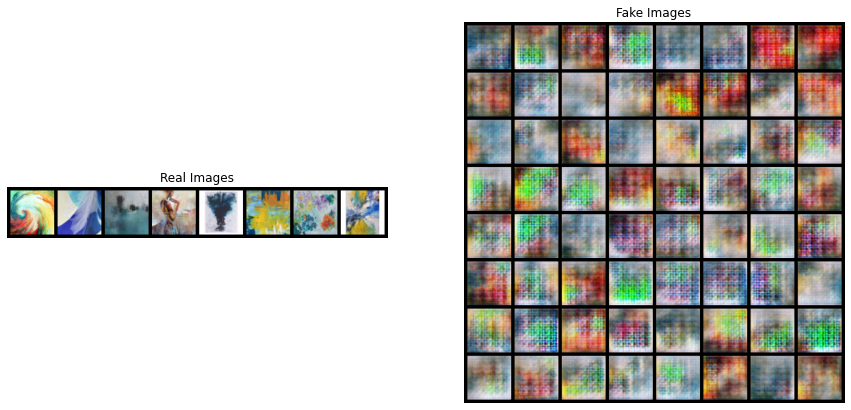

In [15]:
# makes the image list
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=5, normalize=True))

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### A random image

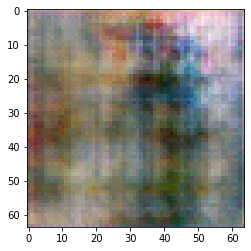

In [16]:
# helper function for converting images to a normal range
def img_scale(img_tensor):
    min_value = img_tensor.min()
    span = img_tensor.max() - img_tensor.min()
    img_tensor = (img_tensor - min_value) / span
    img_tensor = np.transpose(img_tensor)

    return img_tensor

noise = torch.randn(b_size, GEN_INPUT_SIZE, 1, 1, device=device)
output = netG(noise).detach().cpu()
plt.imshow(img_scale(output[0]))

In [0]:
# real image
